## Homework 08

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, TimeDistributed, LSTM, GlobalAvgPool2D, AbstractRNNCell, MaxPooling2D, RNN
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tqdm
from sklearn.manifold import TSNE

# magic line only needed in jupyter notebooks!
%reload_ext tensorboard

2023-01-08 23:29:05.678327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 23:29:05.867382: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### 2.1 Prepare the Dataset

In [111]:
def load_mnist_dataset(noise_factor):
    # Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Convert the images to float32 and normalize them
    x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

    # Add a third dimension to the images
    x_train = tf.expand_dims(x_train, axis=-1)
    x_test = tf.expand_dims(x_test, axis=-1)

    # Create a random noise tensor
    noise = noise_factor * tf.random.normal(shape=tf.shape(x_train))

    # Add the noise to the images
    x_train_noisy = x_train + noise
    x_train_noisy = tf.clip_by_value(x_train_noisy, 0, 1)

    noise = noise_factor * tf.random.normal(shape=tf.shape(x_test))
    x_test_noisy = x_test + noise
    x_test_noisy = tf.clip_by_value(x_test_noisy, 0, 1)

    # Construct a tf.data.Dataset for training and testing
    batch_size = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train)).shuffle(10000).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test)).shuffle(10000).batch(batch_size)

    # Use prefetch to improve the performance of the data pipeline
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return train_dataset, test_dataset


In [112]:
noise_factor = 0.5
training_data, testing_data = load_mnist_dataset(noise_factor)

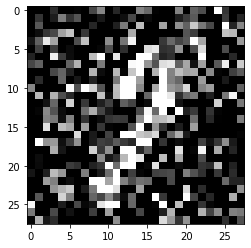

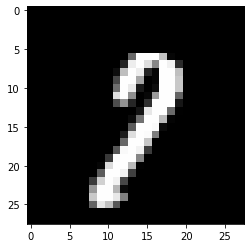

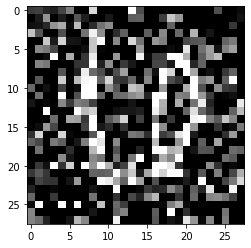

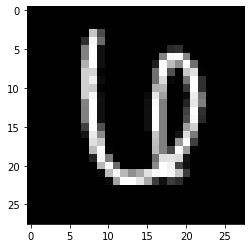

In [113]:
def print_noisy_image(dataset):
    # Get an image and its label from the dataset
    image, label = next(iter(dataset))

    # Get the first image from the batch
    image = image[0]
    image_2 = label[0]

    # Remove the extra dimension
    image = tf.squeeze(image, axis=-1)
    image_2 = tf.squeeze(image_2, axis=-1)

    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.show()
    plt.imshow(image_2, cmap='gray')
    plt.show()

# Print an image from the train_dataset
print_noisy_image(training_data)

# Print an image from the test_dataset
print_noisy_image(testing_data)


### 2.2 The Model
#### Convolutional Autoencoder

In [114]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        
        super().__init__()
        
        # optimzer, metrics, loss
        self.optimizer = tf.keras.optimizers.Adam()

        self.metrics_list = [
                        tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc") 
                       ]

        self.loss_function = tf.keras.losses.BinaryCrossentropy()

        # Encoder
        self.conv_1 = layers.Conv2D(filters=24, kernel_size=3, activation="relu", padding="same")
        self.maxpool = layers.MaxPooling2D(pool_size=2, padding="same")
        self.conv_2 = layers.Conv2D(filters=24, kernel_size=3, activation="relu", padding="same")
        self.globalpool = layers.MaxPooling2D(pool_size=2, padding="same")

        # Decoder
        self.transconv_1 = layers.Conv2DTranspose(filters=24, kernel_size=3, strides=2, activation="relu", padding="same")
        self.transconv_2 = layers.Conv2DTranspose(filters=24, kernel_size=3, strides=2, activation="relu", padding="same")
        self.conv_3 = layers.Conv2D(filters=1, kernel_size=3, activation="sigmoid", padding="same")

    # call funtion
    @tf.function
    def call(self, x):
        x = self.conv_1(x)
        x = self.maxpool(x)
        x = self.conv_2(x)
        x = self.globalpool(x)
        
        x = self.transconv_1(x)
        x = self.transconv_2(x)
        x = self.conv_3(x)
        return x
    
    # metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model

    # reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
    
    # train step method
    @tf.function
    def train_step(self, data):
        
        x, targets = data
        
        # calculate and backpropagate gradients
        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            loss = self.loss_function(targets, predictions) + tf.reduce_sum(self.losses)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update loss metric
        self.metrics[0].update_state(loss)
        
        # update accuracy
        for metric in self.metrics[1:]:
            metric.update_state(targets,predictions)

        # Return a dictionary mapping metric names to current value to keep track of training
        d = {m.name: m.result() for m in self.metrics}
        return d

    @tf.function
    def test_step(self, data):
        
        # same as in training but without backpropagating
        x, targets = data
        predictions = self(x, training=False)
        loss = self.loss_function(targets, predictions) + tf.reduce_sum(self.losses)
        # update loss metric
        self.metrics[0].update_state(loss)
        # update accuracy metric
        for metric in self.metrics[1:]:
            metric.update_state(targets, predictions)

        d = {m.name: m.result() for m in self.metrics}
        return d, targets, predictions

### 2.3 Training

Something is wrong with the metrics (probably some deeper issue).
The accuracy is always 1.0 and the loss seems inaproprietly low (maybe).

In [115]:
def print_progress(e, predictions):
    # Get the first image from the batch
    image = predictions[e]

    # Remove the extra dimension
    image = tf.squeeze(image, axis=-1)

    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.show()

In [116]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer):

    # iterate over epochs
    for e in range(epochs):

        # train steps on all batches in the training data
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)

        # log and print Ltraining metrics
        with train_summary_writer.as_default():
            # for scalar metrics:
            for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
            # alternatively, log metrics individually (allows for non-scalar metrics such as tf.keras.metrics.MeanTensor)
            # e.g. tf.summary.image(name="mean_activation_layer3", data = metrics["mean_activation_layer3"],step=e)
        
        #print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        
        # 4. reset metric objects
        model.reset_metrics()


        # 5. evaluate on validation data
        for data in test_ds:
            metrics, targets, predictions = model.test_step(data)
        
        # log validation metrics
        with test_summary_writer.as_default():
            # for scalar metrics:
            for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
            # alternatively, log metrics individually (allows for non-scalar metrics such as tf.keras.metrics.MeanTensor)
            # e.g. tf.summary.image(name="mean_activation_layer3", data = metrics["mean_activation_layer3"],step=e)
            
        print([f"test_{key}: {value.numpy()}" for (key, value) in metrics.items()])
        # print the progress in "denoising the images"
        print_progress(e, predictions)
        print_progress(e, targets)
        # 7. reset metric objects
        model.reset_metrics()

In [117]:
def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    test_log_path = f"logs/{config_name}/{current_time}/test"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for test metrics
    test_summary_writer = tf.summary.create_file_writer(test_log_path)
    
    return train_summary_writer, test_summary_writer

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 108.01it/s]


['loss: 0.1376524716615677', 'acc: 1.0']
['test_loss: 0.11060522496700287', 'test_acc: 1.0']


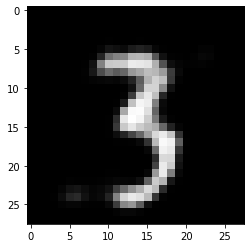

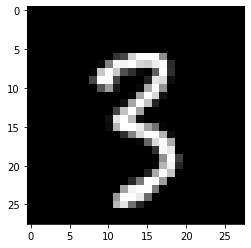

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 105.98it/s]


['loss: 0.10920610278844833', 'acc: 1.0']
['test_loss: 0.1059766635298729', 'test_acc: 1.0']


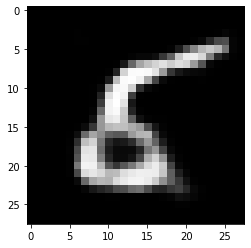

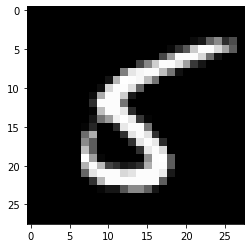

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 106.90it/s]


['loss: 0.10558439046144485', 'acc: 1.0']
['test_loss: 0.10337802767753601', 'test_acc: 1.0']


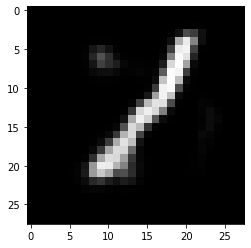

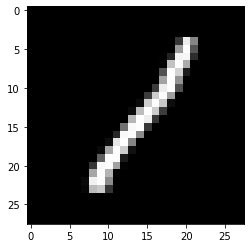

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 110.24it/s]


['loss: 0.10337729007005692', 'acc: 1.0']
['test_loss: 0.10180135816335678', 'test_acc: 1.0']


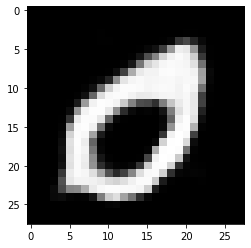

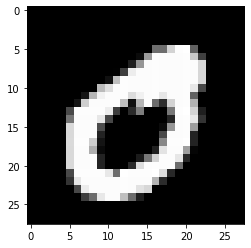

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 109.63it/s]


['loss: 0.10185079276561737', 'acc: 1.0']
['test_loss: 0.10066152364015579', 'test_acc: 1.0']


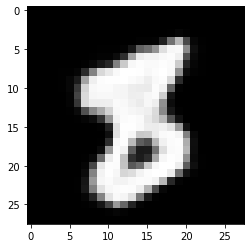

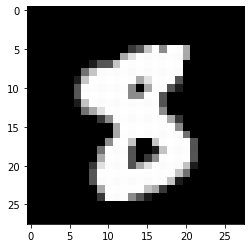

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 108.52it/s]


['loss: 0.1007762998342514', 'acc: 1.0']
['test_loss: 0.10046333074569702', 'test_acc: 1.0']


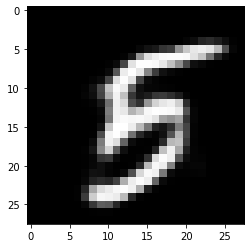

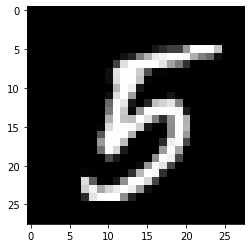

100%|██████████████████████████████████████| 1875/1875 [00:18<00:00, 100.81it/s]


['loss: 0.10011227428913116', 'acc: 1.0']
['test_loss: 0.09977961331605911', 'test_acc: 1.0']


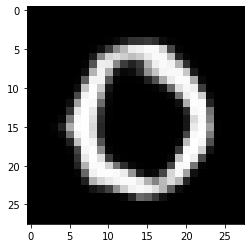

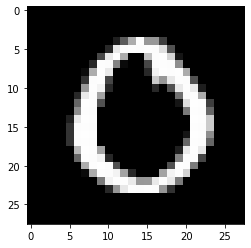

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 104.73it/s]


['loss: 0.09956598281860352', 'acc: 1.0']
['test_loss: 0.09878428280353546', 'test_acc: 1.0']


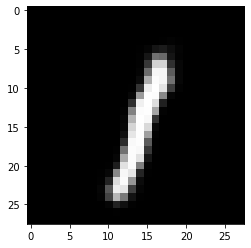

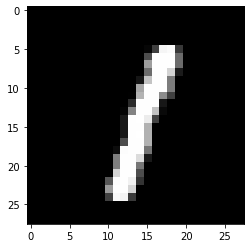

100%|██████████████████████████████████████| 1875/1875 [00:18<00:00, 100.83it/s]


['loss: 0.09915895760059357', 'acc: 1.0']
['test_loss: 0.09841103851795197', 'test_acc: 1.0']


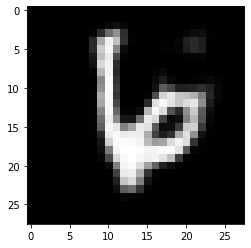

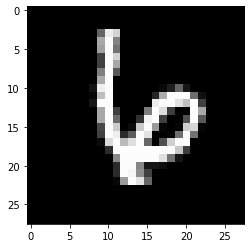

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 107.80it/s]


['loss: 0.09881462156772614', 'acc: 1.0']
['test_loss: 0.09826458245515823', 'test_acc: 1.0']


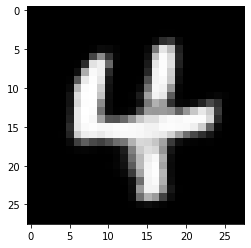

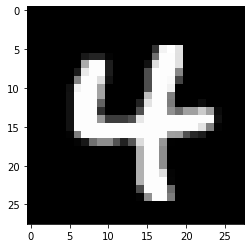

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 107.10it/s]


['loss: 0.09850572049617767', 'acc: 1.0']
['test_loss: 0.09785694628953934', 'test_acc: 1.0']


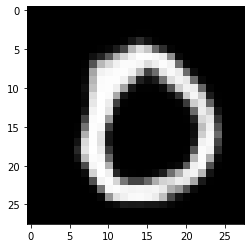

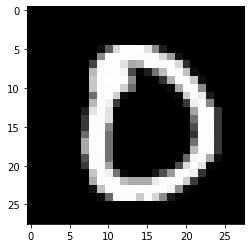

100%|██████████████████████████████████████| 1875/1875 [00:18<00:00, 102.63it/s]


['loss: 0.09827780723571777', 'acc: 1.0']
['test_loss: 0.09822990745306015', 'test_acc: 1.0']


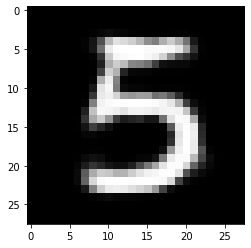

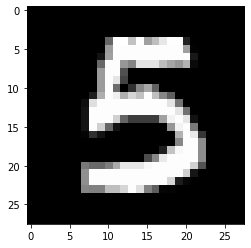

100%|██████████████████████████████████████| 1875/1875 [00:18<00:00, 101.20it/s]


['loss: 0.09805941581726074', 'acc: 1.0']
['test_loss: 0.09757083654403687', 'test_acc: 1.0']


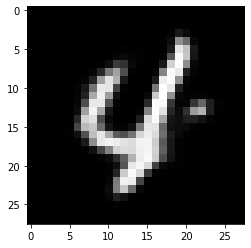

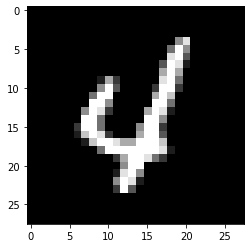

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 105.21it/s]


['loss: 0.0979275330901146', 'acc: 1.0']
['test_loss: 0.09733783453702927', 'test_acc: 1.0']


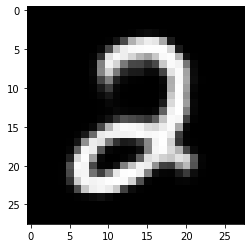

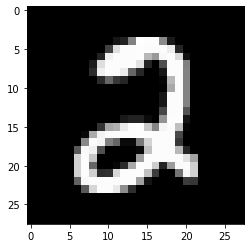

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 105.86it/s]


['loss: 0.09773577749729156', 'acc: 1.0']
['test_loss: 0.09710142016410828', 'test_acc: 1.0']


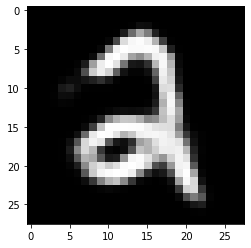

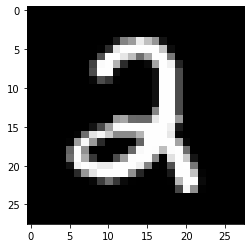

In [118]:
train_summary_writer, test_summary_writer = create_summary_writers("model_1")
model = Autoencoder()
training_loop(model, 
              train_ds=training_data, 
              test_ds=testing_data, 
              epochs= 15, 
              train_summary_writer=train_summary_writer, 
              test_summary_writer=test_summary_writer)

### 2.4 Latent Space Analysis

I am attempting to feed 1000 noisy images through the encoder, which gives me 1000 embeddings of the shape (7, 7, 24).
Then I use the TSNE transformer and fit_transformer to reduce the dimension of each embedding to 2.
It didn't work at first, so I flattened the embedding (since the transformer seems to want a flattened image?).
Finally I attempted plotting each embedding (with respective color and "digit image")
I (almost entirely) stole the visualization from here: https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py

It looks kind of ok? Not entirely sure what anything means and if any of this even makes sense... 

In [100]:
# create exactly 1000 of the noisy test images plus targets
def batch_1000_test_images(noise_factor):
    # Load the MNIST dataset
    _, (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Convert the images to float32 and normalize them
    x_test = x_test.astype('float32') / 255.0

    x_test = tf.expand_dims(x_test, axis=-1)

    noise = noise_factor * tf.random.normal(shape=tf.shape(x_test))
    x_test_noisy = x_test + noise
    x_test_noisy = tf.clip_by_value(x_test_noisy, 0, 1)
    
    data = tf.data.Dataset.from_tensor_slices((x_test_noisy, y_test)).shuffle(10000).batch(1000).take(1)
    
    for d in data:
        x, y = d
    
    return x, y

In [109]:
x, y = batch_1000_test_images(0.5)
print(x.shape)
k = tf.reshape(x, (1000, -1))
x = layers.Conv2D(filters=24, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
x = layers.Conv2D(filters=24, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
embeddings = layers.Flatten()(x)

print(embeddings.shape)
n_neighbors = 30
# X_embedded = TSNE(n_components=1000, learning_rate='auto', init='random', perplexity=3).fit_transform(embeddings)

(1000, 28, 28, 1)
(1000, 1176)


In [105]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, y, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[np.where(y==digit)].T,
            # this lets us know which "digit image" to use
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Paired(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

/home/marie/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/marie/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[ -4.700489     6.8285775 ]
 [ -7.354797    14.839239  ]
 [  8.035352    -5.2159867 ]
 ...
 [  3.2450902   21.607164  ]
 [ -2.51296    -21.607792  ]
 [  0.68312085  11.176073  ]]


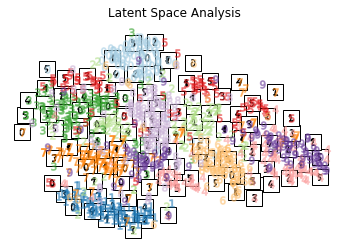

In [107]:
X = TSNE(n_components=2,n_iter=500,n_iter_without_progress=150,n_jobs=2,random_state=0).fit_transform(embeddings)
print(X)
plot_embedding(X, y, "Latent Space Analysis")